In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf # YahooFinance
import pandas_ta as ta  # Teknik Analiz Kütüphanesi
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import warnings

# Uyarıları gizle
warnings.filterwarnings('ignore')

print(f"Numpy Sürümü: {np.__version__}")

Numpy Sürümü: 1.26.4


In [8]:
# Hisse Kodları
TICKER_CONFIG = {
    "^IXIC": {"sma": 10, "ema": 7},
    "AAPL":  {"sma": 20, "ema": 4},
    "NVDA":  {"sma": 10, "ema": 4},
    "TSLA":  {"sma": 20, "ema": 50},
    "MSFT":  {"sma": 13, "ema": 10},
    "GOOGL": {"sma": 50, "ema": 10} 
}

# Sabit MACD Ayarları
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9

In [9]:
# Veriyi çekiyoruz ve indikatörleri hesaplıyoruz
# ML için Özellikler(Features) tanımlıyoruz
def get_data_with_features(ticker, sma_len, ema_len):
    print(f"{ticker} verileri ve ML özellikleri hazırlanıyor... (SMA: {sma_len}, EMA: {ema_len})")
    # Veriyi çek
    df = yf.download(ticker, start="2010-01-01", progress=False)
    
    # Multi-index düzeltmesi(verilerin doğru gelmesi için)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    # Temel Strateji Hesaplamaları
    df['SMA_Base'] = ta.sma(df['Close'], length=sma_len)
    df['EMA_Signal'] = ta.ema(df['Close'], length=ema_len)
    
    macd = ta.macd(df['Close'], fast=MACD_FAST, slow=MACD_SLOW, signal=MACD_SIGNAL)
    df['MACD_Line'] = macd[f'MACD_{MACD_FAST}_{MACD_SLOW}_{MACD_SIGNAL}']

    # Model bu verilere bakarak "Başarılı İşlem Şablonunu" öğrenecek
    # Modelin karar verirken kullanacağı hesaplamalar:
    # 1.RSI: Aşırı alım/satım durumu
    df['RSI'] = ta.rsi(df['Close'], length=14)
    
    # 2.SMA Uzaklığı: Fiyatın SMA'ya uzaklığı(Yüzdesel)
    df['Dist_SMA'] = (df['Close'] - df['SMA_Base']) / df['SMA_Base']
    
    # 3.ATR Yüzdesi: Volatilite(Risk) durumu
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    df['ATR_Pct'] = df['ATR'] / df['Close']

    # 4.ROC: Momentum(Değişim Hızı)
    df['ROC'] = ta.roc(df['Close'], length=5)
    
    # 5.Hacim Değişimi: Hacim ortalamanın üstünde mi?
    df['Vol_SMA'] = ta.sma(df['Volume'], length=20)
    df['Vol_Ratio'] = df['Volume'] / df['Vol_SMA']
    
    df.dropna(inplace=True)
    return df

In [10]:
# Strateji
def strategy(df):
    # 1. Ana Trend (SMA_Base kullanıyoruz)
    cond_Trend = df['Close'] > df['SMA_Base']
    # 2. Momentum (EMA_Signal kullanıyoruz)
    cond_Momentum = df['Close'] > df['EMA_Signal']
    # 3. MACD > 0
    cond_Macd = df['MACD_Line'] > 0
    
    # Durumlar (Boğa ve Ayı trendleri)
    is_bearish = df['Close'] < df['SMA_Base']
    is_bullish = cond_Trend & cond_Momentum & cond_Macd

    # Renk Ataması
    # Kırmızı veya Yeşil değilse -> Gri(Nötr)
    conditions = [is_bearish, is_bullish]
    choices = ['RED', 'GREEN']
    df['Color'] = np.select(conditions, choices, default='GRAY')
    
    return df

In [11]:
# # ML Verisi Hazırlama (Eğitim Seti için)
# Bu fonksiyon, Eğitim setindeki işlemleri simüle eder ve
# Karlı işlemse 1, Zararlıysa 0 etiketini yapıştırır.
def prepare_ml_dataset(df):
    colors = df['Color'].values
    prices = df['Close'].values
    dates = df.index
    
    # ML için Özellikler(Features)
    feature_cols = ['RSI', 'Dist_SMA', 'ATR_Pct', 'Vol_Ratio', 'ROC']
    X = [] # Futures tutan liste
    y = [] # Sonuç(1: Başarılı, 0: Başarısız)
    indices = [] # Hangi indexte işlem oldu?
    
    in_trade = False
    entry_price = 0
    
    # Geçici listeler
    current_trade_features = []
    
    for i in range(1, len(df)):
        buy_signal = (colors[i] == 'GREEN') and (colors[i-1] == 'GRAY')
        sell_signal = in_trade and (colors[i] != 'GREEN')
        
        if buy_signal and not in_trade:
            in_trade = True
            entry_price = prices[i]
            
            # İşleme girdiğimiz andaki özellikleri (RSI, ATR vb.) al
            features = df.iloc[i][feature_cols].values
            current_trade_features = features
            
        elif sell_signal:
            in_trade = False
            exit_price = prices[i]
            
            pnl = (exit_price - entry_price) / entry_price
            
            # Labeling(Etiketleme)
            # Eğer kar ettiysek 1, zarar ettiysek 0
            label = 1 if pnl > 0 else 0
            
            # Listeye ekle
            X.append(current_trade_features)
            y.append(label)
            indices.append(i) # İşlemin bittiği değil başladığı yerin verisini alıyoruz.
            
    return np.array(X), np.array(y), feature_cols

In [12]:
# Model Eğitimi
def train_model(X_train, y_train):
    # Random Forest Modeli
    # n_estimators=100 : 100 tane karar ağacı
    # max_depth=5 : Ağaçlar çok derinleşip ezberlemesin
    rf = RandomForestClassifier(n_estimators=90, max_depth=6, min_samples_leaf=2, random_state=42)
    rf.fit(X_train, y_train)
    return rf

In [13]:
# Bu fonksiyon TEST verisinde çalışır. Hem normal stratejiyi hem ML'i karşılaştırır.
def compare_backtest(df, model, feature_cols):
    trades_main = [] # Normal Strateji
    trades_ml = []  # Model ile filtreli Strateji
    
    # Ana stratejinin değişkenleri
    in_trade_main = False     # Şu an elimizde hisse var mı? Başlangıçta yok(False)
    entry_price_main = 0      # Hisse alış fiyatı
    entry_date_main = None   # Hisse satış fiyatı

    # Modelin değişkenleri
    in_trade_ml = False
    entry_price_ml = 0
    entry_date_ml = None

    # Renkleri, tarihleri ve fiyat değerlerini array'lere aktarıyoruz.
    colors = df['Color'].values
    prices = df['Close'].values
    dates = df.index
    # Feature verilerini hızlı erişim için numpy array yapıyoruz.
    features_data = df[feature_cols].values

    # Al ve Sat pozisyonları
    for i in range(1, len(df)):
        current_color = colors[i]  # Bugünün Rengi
        prev_color = colors[i-1]   # Dünün Rengi
        
        # Sinyaller (Her ikisi için ortak temel sinyal)
        # AL SİNYALİ: Şu an ki mum YEŞİL ve önceki günün rengi GRİ
        main_buy_signal = (current_color == 'GREEN') and (prev_color == 'GRAY')
        # SAT SİNYALİ: İşlemdeyiz ve artık YEŞİL değiliz, yeşilden griye veya kırmızıya geçtik.
        sell_signal_cond = (current_color != 'GREEN') 
        
        # 1.Durum: MODEL yok
        # Eğer main_buy_signal geldiyse ve elimizde mal yoksa (not in_trade), alım yapıyoruz ve durumu güncelliyoruz.
        if main_buy_signal and not in_trade_main:
            in_trade_main = True           # Pozisyon açık
            entry_price_main = prices[i]   # Aldığımız fiyatı kaydet
            entry_date_main = dates[i]     # Aldığımız tarihi kaydet
        elif in_trade_main and sell_signal_cond:
            in_trade_main = False          # Pozisyon kapandı
            pnl = ((prices[i] - entry_price_main) / entry_price_main) * 100  # Pnl'i hesapla
            # İşlemi kaydet
            trades_main.append({
                'Entry_Date': entry_date_main, 
                'Exit_Date': dates[i], 
                'PnL': pnl, 
                'Duration': (dates[i] - entry_date_main).days
            })

        # 2.Durum: ML filtreli
        # Eğer main_buy_signal geldiyse ve elimizde mal yoksa (not in_trade), alım yapıyoruz ve durumu güncelliyoruz.
        if main_buy_signal and not in_trade_ml:
            # Modele soruyoruz: "Bu sinyale gireyim mi?"
            current_feats = features_data[i].reshape(1, -1)
            prediction = model.predict(current_feats)[0] # 1 (Evet) veya 0 (Hayır)
            
            if prediction == 1: # Model onaylarsa gir
                in_trade_ml = True
                entry_price_ml = prices[i]
                entry_date_ml = dates[i]

        # Pozisyonda ise ve sell_signal_cond tamamlandı ise:
        elif in_trade_ml and sell_signal_cond:
            in_trade_ml = False  # Pozisyonu kapat
            pnl = ((prices[i] - entry_price_ml) / entry_price_ml) * 100  # Pnl hesapla
            # İşlemi kaydet
            trades_ml.append({
                'Entry_Date': entry_date_ml, 
                'Exit_Date': dates[i], 
                'PnL': pnl, 
                'Duration': (dates[i] - entry_date_ml).days
            })
    return pd.DataFrame(trades_main), pd.DataFrame(trades_ml)

In [14]:
# Metrikleri hesaplıyoruz.
def calculate_metrics(trades_df):
    # Eğer işlem yoksa boş bir sözlük döndür (Error vermemesi için)
    if trades_df.empty:
        return {
            "Toplam İşlem": 0,
            "En Uzun Trend (Gün)": 0,
            "En Kısa Trend (Gün)": 0,
            "Trendde Geçen Toplam Gün Sayısı (Gün)": 0,
            "Toplam Getiri Yüzdesi (%)": 0.0,
            "Ort. Trend Süresi (Gün)": 0.0,
            "Ortalama Getiri (%)": 0.0,
            "En Yüksek Getiri (%)": 0.0,
            "En Düşük Getiri (%)": 0.0,
            "Başarılı Trend Oranı (%)": 0.0,
            "Başarısız Trend Oranı (%)": 0.0
        }

    # Temel Değişkenler
    win_count = len(trades_df[trades_df['PnL'] > 0])
    total_count = len(trades_df)
    loss_count = total_count - win_count
    
    # Oranlar
    win_rate = (win_count / total_count) * 100
    loss_rate = (loss_count / total_count) * 100

    return {
        "Toplam İşlem": total_count,
        "En Uzun Trend (Gün)": round(trades_df['Duration'].max(), 1),
        "En Kısa Trend (Gün)": round(trades_df['Duration'].min(), 1),
        "Trendde Geçen Toplam Gün Sayısı (Gün)": int(trades_df['Duration'].sum()),
        "Toplam Getiri Yüzdesi (%)": round(trades_df['PnL'].sum(), 2),
        "Ort. Trend Süresi (Gün)": round(trades_df['Duration'].mean(), 1),
        "Ortalama Getiri (%)": round(trades_df['PnL'].mean(), 2),
        "En Yüksek Getiri (%)": round(trades_df['PnL'].max(), 2),
        "En Düşük Getiri (%)": round(trades_df['PnL'].min(), 2),
        "Başarılı Trend Oranı (%)": round(win_rate, 1),
        "Başarısız Trend Oranı (%)": round(loss_rate, 1)
    }


==================== ANALİZ: ^IXIC ====================
^IXIC verileri ve ML özellikleri hazırlanıyor... (SMA: 10, EMA: 7)
-> Model Eğitiliyor (72 işlem örneği ile)...

--- TEST SONUÇLARI KARŞILAŞTIRMASI ---
                                       NORMAL STRATEJİ  ML DESTEKLİ (Filtreli)
Toplam İşlem                                     26.00                   13.00
En Uzun Trend (Gün)                              26.00                   26.00
En Kısa Trend (Gün)                               1.00                    1.00
Trendde Geçen Toplam Gün Sayısı (Gün)           241.00                  145.00
Toplam Getiri Yüzdesi (%)                         4.06                    8.94
Ort. Trend Süresi (Gün)                           9.30                   11.20
Ortalama Getiri (%)                               0.16                    0.69
En Yüksek Getiri (%)                              6.56                    5.83
En Düşük Getiri (%)                              -2.94                   -2.18
B

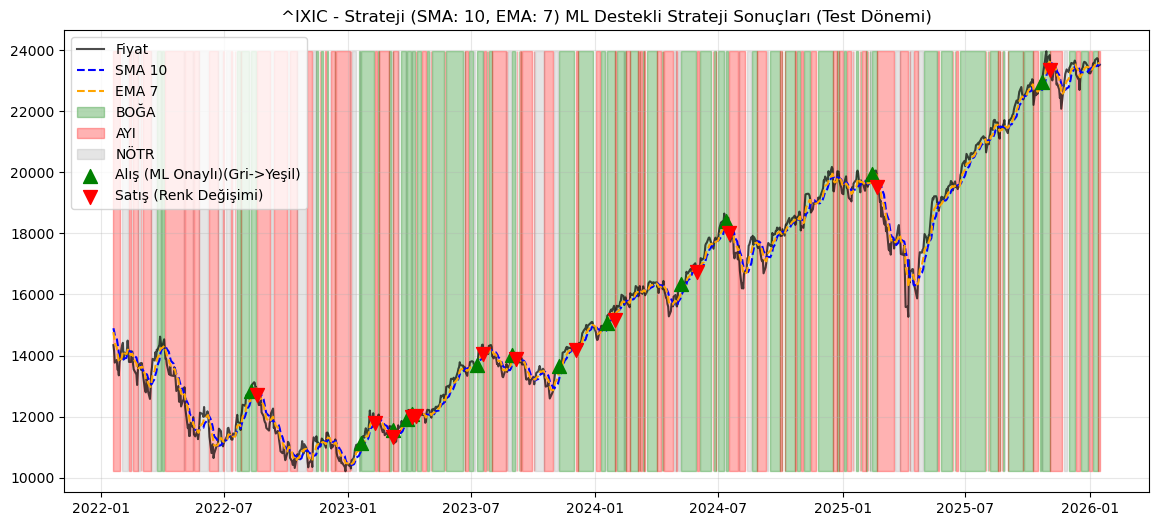


==================== ANALİZ: AAPL ====================
AAPL verileri ve ML özellikleri hazırlanıyor... (SMA: 20, EMA: 4)
-> Model Eğitiliyor (190 işlem örneği ile)...

--- TEST SONUÇLARI KARŞILAŞTIRMASI ---
                                       NORMAL STRATEJİ  ML DESTEKLİ (Filtreli)
Toplam İşlem                                     60.00                   19.00
En Uzun Trend (Gün)                              26.00                   20.00
En Kısa Trend (Gün)                               1.00                    1.00
Trendde Geçen Toplam Gün Sayısı (Gün)           389.00                  144.00
Toplam Getiri Yüzdesi (%)                        15.27                    6.64
Ort. Trend Süresi (Gün)                           6.50                    7.60
Ortalama Getiri (%)                               0.25                    0.35
En Yüksek Getiri (%)                              9.55                    4.99
En Düşük Getiri (%)                              -3.77                   -3.46
Ba

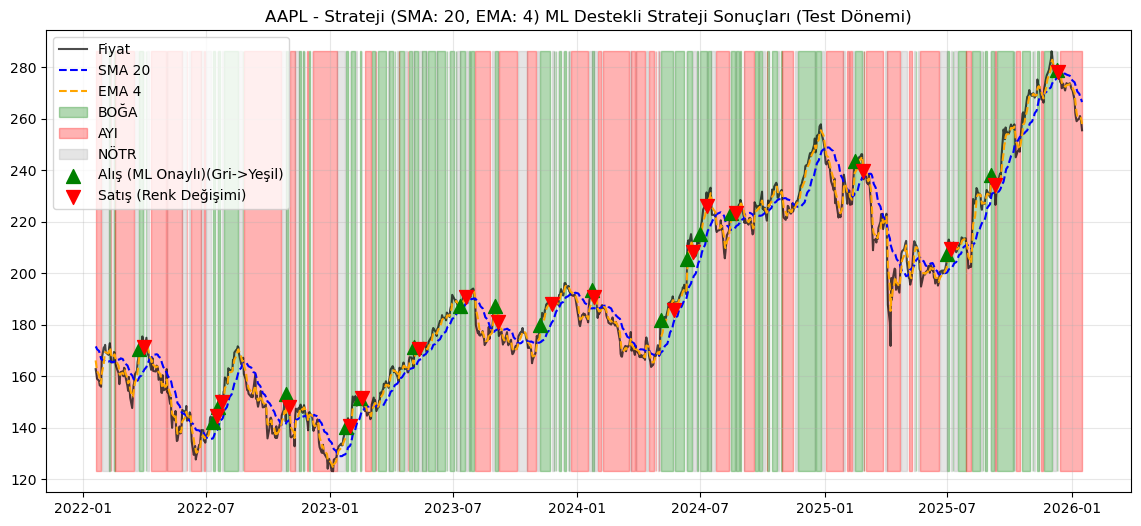


==================== ANALİZ: NVDA ====================
NVDA verileri ve ML özellikleri hazırlanıyor... (SMA: 10, EMA: 4)
-> Model Eğitiliyor (139 işlem örneği ile)...

--- TEST SONUÇLARI KARŞILAŞTIRMASI ---
                                       NORMAL STRATEJİ  ML DESTEKLİ (Filtreli)
Toplam İşlem                                     52.00                    6.00
En Uzun Trend (Gün)                              20.00                   12.00
En Kısa Trend (Gün)                               1.00                    2.00
Trendde Geçen Toplam Gün Sayısı (Gün)           305.00                   31.00
Toplam Getiri Yüzdesi (%)                        58.16                   -8.20
Ort. Trend Süresi (Gün)                           5.90                    5.20
Ortalama Getiri (%)                               1.12                   -1.37
En Yüksek Getiri (%)                             15.80                    2.65
En Düşük Getiri (%)                              -4.82                   -4.82
Ba

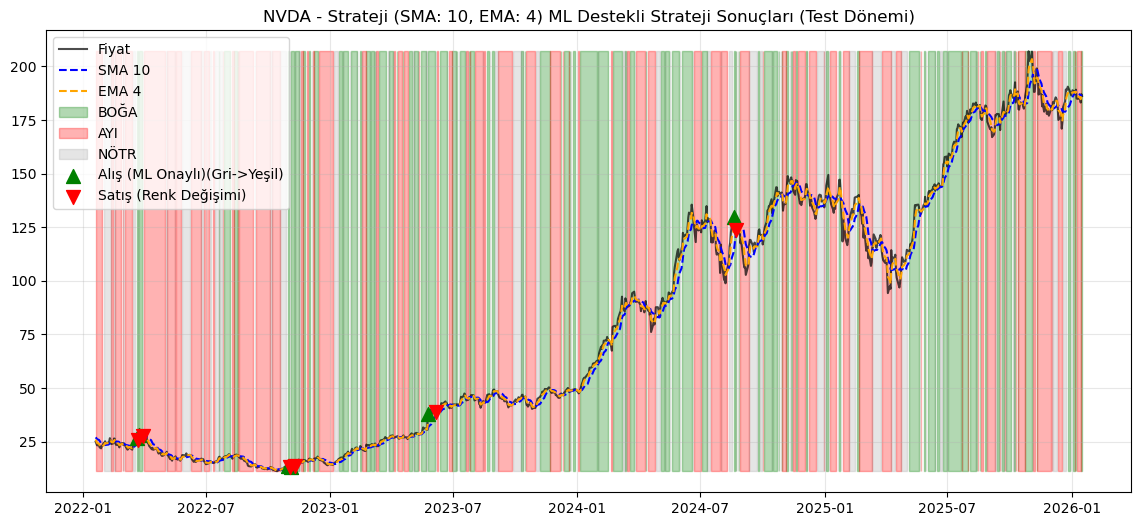


==================== ANALİZ: TSLA ====================
TSLA verileri ve ML özellikleri hazırlanıyor... (SMA: 20, EMA: 50)
-> Model Eğitiliyor (49 işlem örneği ile)...

--- TEST SONUÇLARI KARŞILAŞTIRMASI ---
                                       NORMAL STRATEJİ  ML DESTEKLİ (Filtreli)
Toplam İşlem                                     19.00                    2.00
En Uzun Trend (Gün)                              67.00                   34.00
En Kısa Trend (Gün)                               1.00                    7.00
Trendde Geçen Toplam Gün Sayısı (Gün)           348.00                   41.00
Toplam Getiri Yüzdesi (%)                        72.78                    1.60
Ort. Trend Süresi (Gün)                          18.30                   20.50
Ortalama Getiri (%)                               3.83                    0.80
En Yüksek Getiri (%)                             50.02                    7.31
En Düşük Getiri (%)                              -8.45                   -5.71
Ba

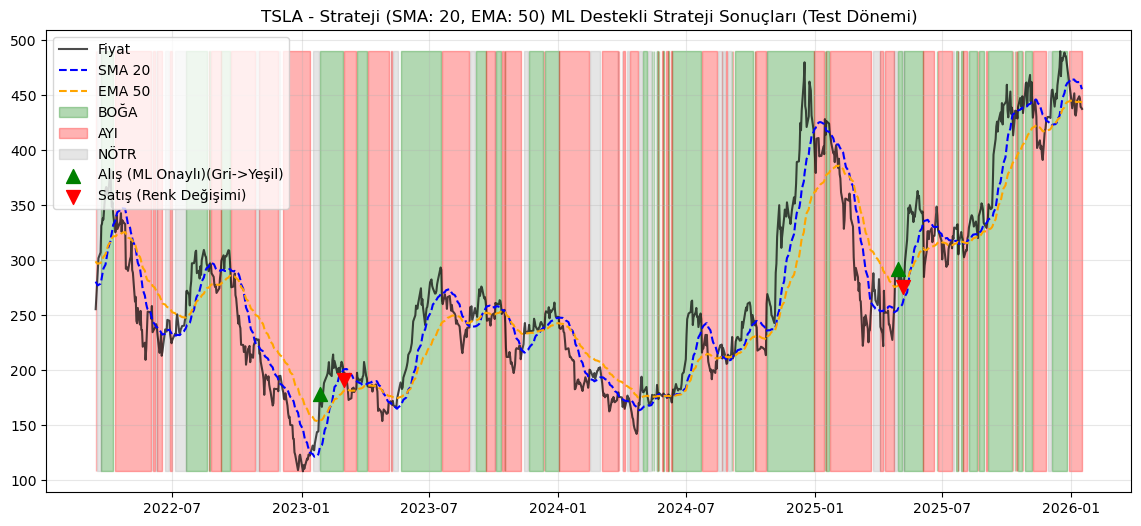


==================== ANALİZ: MSFT ====================
MSFT verileri ve ML özellikleri hazırlanıyor... (SMA: 13, EMA: 10)
-> Model Eğitiliyor (80 işlem örneği ile)...

--- TEST SONUÇLARI KARŞILAŞTIRMASI ---
                                       NORMAL STRATEJİ  ML DESTEKLİ (Filtreli)
Toplam İşlem                                     18.00                     0.0
En Uzun Trend (Gün)                             100.00                     0.0
En Kısa Trend (Gün)                               1.00                     0.0
Trendde Geçen Toplam Gün Sayısı (Gün)           247.00                     0.0
Toplam Getiri Yüzdesi (%)                        12.68                     0.0
Ort. Trend Süresi (Gün)                          13.70                     0.0
Ortalama Getiri (%)                               0.70                     0.0
En Yüksek Getiri (%)                             32.42                     0.0
En Düşük Getiri (%)                              -7.10                     0.0
Ba

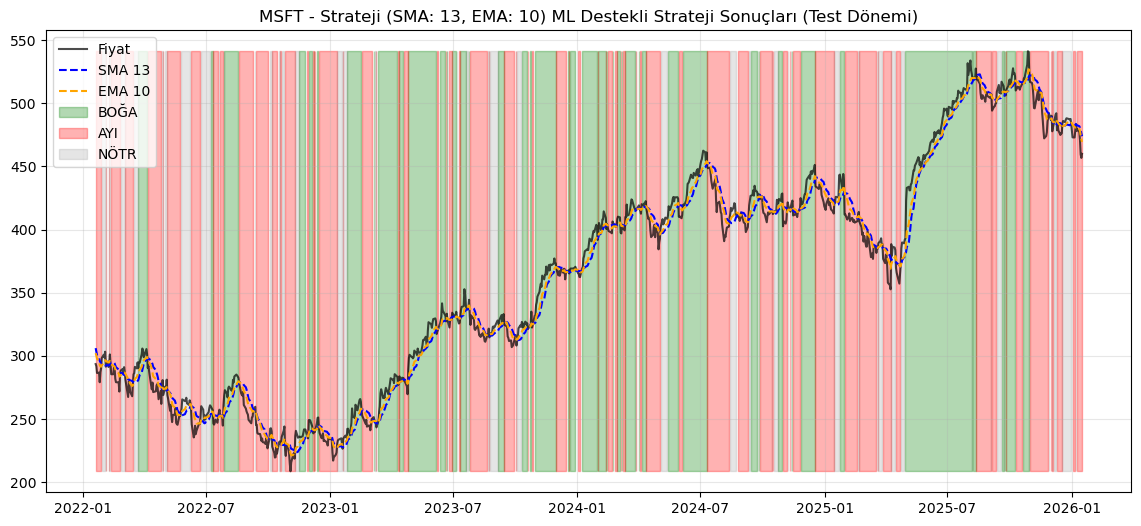


==================== ANALİZ: GOOGL ====================
GOOGL verileri ve ML özellikleri hazırlanıyor... (SMA: 50, EMA: 10)
-> Model Eğitiliyor (162 işlem örneği ile)...

--- TEST SONUÇLARI KARŞILAŞTIRMASI ---
                                       NORMAL STRATEJİ  ML DESTEKLİ (Filtreli)
Toplam İşlem                                     52.00                    8.00
En Uzun Trend (Gün)                              34.00                   28.00
En Kısa Trend (Gün)                               1.00                    1.00
Trendde Geçen Toplam Gün Sayısı (Gün)           560.00                   98.00
Toplam Getiri Yüzdesi (%)                        54.55                   13.58
Ort. Trend Süresi (Gün)                          10.80                   12.20
Ortalama Getiri (%)                               1.05                    1.70
En Yüksek Getiri (%)                             19.37                   11.64
En Düşük Getiri (%)                              -9.51                   -4.52

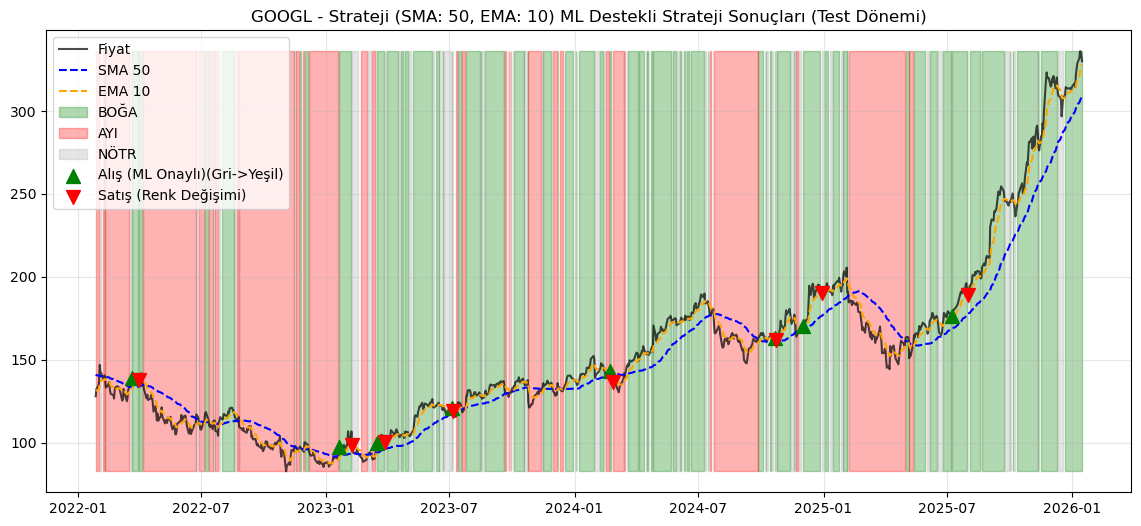

In [15]:
# Ana Döngü ve Görselleştirme
for ticker, params in TICKER_CONFIG.items():
    print(f"\n{'='*20} ANALİZ: {ticker} {'='*20}")

    custom_sma = params['sma']
    custom_ema = params['ema']
    
    # 1.Veri Hazırla
    df = get_data_with_features(ticker, custom_sma, custom_ema)
    df = strategy(df)
    
    # 2.Train/Test Ayrımı(%75-%25)
    split_idx = int(len(df) * 0.75)
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    
    # 3.Model Eğitimi(Train kısmı)
    X_train, y_train, f_cols = prepare_ml_dataset(train_df)
    
    if len(X_train) > 10:
        print(f"-> Model Eğitiliyor ({len(X_train)} işlem örneği ile)...")
        rf_model = train_model(X_train, y_train)
        
        # 4.Kıyaslamalı Backtest(Test kısmı)
        # main_trades = Modelsiz Strateji
        # ml_trades = Model Filtreli Strateji
        main_trades, ml_trades = compare_backtest(test_df, rf_model, f_cols)
        
        # 5.Metrik Hesaplama
        main_metrics = calculate_metrics(main_trades)
        ml_metrics = calculate_metrics(ml_trades)
        
        # Sonuç Tablosu
        results = pd.DataFrame([main_metrics, ml_metrics], index=["NORMAL STRATEJİ", "ML DESTEKLİ (Filtreli)"])
        print("\n--- TEST SONUÇLARI KARŞILAŞTIRMASI ---")
        print(results.T)  # Transpose ederek daha okunaklı yapıyoruz.
        
        diff = ml_metrics["Ortalama Getiri (%)"] - main_metrics["Ortalama Getiri (%)"]
        print(f"\n>> YORUM: ML Modeli, ortlama getiriyi %{diff:.2f} değiştirdi.")

        # 6.Görselleştirme(ML Destekli Sonuçları Çizelim)
        plt.figure(figsize=(14, 6))
        
        # Fiyat ve Ortalamalar
        plt.plot(test_df.index, test_df['Close'], label='Fiyat', color='black', alpha=0.7)
        plt.plot(test_df.index, test_df['SMA_Base'], label=f'SMA {custom_sma}', color='blue', linestyle='--')
        plt.plot(test_df.index, test_df['EMA_Signal'], label=f'EMA {custom_ema}', color='orange', linestyle='--')
        
        # Arka Plan Renklendirme
        # Yeşil
        plt.fill_between(test_df.index, test_df['Close'].min(), test_df['Close'].max(), 
                         where=(test_df['Color'] == 'GREEN'), color='green', alpha=0.3, label='BOĞA')
        # Kırmızı
        plt.fill_between(test_df.index, test_df['Close'].min(), test_df['Close'].max(), 
                         where=(test_df['Color'] == 'RED'), color='red', alpha=0.3, label='AYI')
        # Gri
        plt.fill_between(test_df.index, test_df['Close'].min(), test_df['Close'].max(), 
                         where=(test_df['Color'] == 'GRAY'), color='gray', alpha=0.2, label='NÖTR')
        
        # Alış ve Satış Noktaları (Sadece ML'in onayladıkları)
        # ml_trades tablosunu kullanarak çiziyoruz.
        if not ml_trades.empty:
            plt.scatter(ml_trades['Entry_Date'], test_df.loc[ml_trades['Entry_Date']]['Close'], 
                        marker='^', color='green', s=100, zorder=5, label='Alış (ML Onaylı)(Gri->Yeşil)')
            plt.scatter(ml_trades['Exit_Date'], test_df.loc[ml_trades['Exit_Date']]['Close'], 
                        marker='v', color='red', s=100, zorder=5, label='Satış (Renk Değişimi)')
        
        plt.title(f"{ticker} - Strateji (SMA: {custom_sma}, EMA: {custom_ema}) ML Destekli Strateji Sonuçları (Test Dönemi)")
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.show()

    else:
        print("Yetersiz veri; eğitim setinde modelin öğrenebileceği kadar işlem oluşmadı.")